In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeRegressor 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [2]:
df = pd.read_csv('dataset.csv')
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0


In [3]:
print(df.shape)

(197428, 14)


## Exploratory Data Analysis

In [4]:
df.describe()

,market_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
count,196441.000000,196433.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000
mean,2.978706,2.882352,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065
std,1.524867,1.503771,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830
min,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000
25%,2.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000
50%,3.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000
75%,4.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000
max,6.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000


In [5]:
print(df.duplicated().sum())

0


In [6]:
df.isnull().sum()

market_id                     987
created_at                      0
actual_delivery_time            7
store_id                        0
store_primary_category       4760
order_protocol                995
total_items                     0
subtotal                        0
num_distinct_items              0
min_item_price                  0
max_item_price                  0
total_onshift_partners      16262
total_busy_partners         16262
total_outstanding_orders    16262
dtype: int64

## Data Cleaning & Preprocessing

In [7]:
# Αριθμητικές στήλες - συμπλήρωση με median
for col in ['total_onshift_partners', 'total_busy_partners', 'total_outstanding_orders', 'market_id']:
    df[col] = df[col].fillna(df[col].median())

# Κατηγορική στήλη - συμπλήρωση με 'Unknown'
df['store_primary_category'] = df['store_primary_category'].fillna('Unknown')

# order_protocol - κατηγορική, συμπλήρωση με τη συχνότερη τιμή (mode)
df['order_protocol'] = df['order_protocol'].fillna(df['order_protocol'].mode()[0])

# actual_delivery_time - πολύ λίγα NaNs, μπορούμε να τα διαγράψουμε
df = df.dropna(subset=['actual_delivery_time'])

In [8]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

df["delivery_duration"] = (df["actual_delivery_time"] - df["created_at"]).dt.total_seconds() / 60

In [9]:
df.drop(columns=['created_at', 'actual_delivery_time'], inplace=True)

In [10]:
objcol= df.select_dtypes(['object']).columns
objcol

Index(['store_id', 'store_primary_category'], dtype='object')

In [11]:
col = 'store_primary_category'

# Υπολογισμός cutoff
cutoff = df.shape[0] * 0.05

# Συχνότητα εμφάνισης κάθε κατηγορίας
freqs = df[col].value_counts()
common_cats = freqs[freqs > cutoff].index

# Ομαδοποίηση σπάνιων σε 'Other'
df[col] = df[col].apply(lambda x: x if x in common_cats else 'Other')

# One-hot encoding μόνο για τις κοινές + Other
dummies = pd.get_dummies(df[col], prefix=col).astype(int)
df = pd.concat([df.drop(columns=[col]), dummies], axis=1)

In [12]:
le = LabelEncoder()
df['store_id'] = le.fit_transform(df['store_id'].values)

In [13]:
df.head()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,delivery_duration,store_primary_category_Other,store_primary_category_american,store_primary_category_burger,store_primary_category_mexican,store_primary_category_pizza,store_primary_category_sandwich
0,1.0,5913,1.0,4,3441,4,557,1239,33.0,14.0,21.0,62.983333,0,1,0,0,0,0
1,2.0,6346,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,67.066667,0,0,0,1,0,0
2,3.0,6346,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,29.683333,1,0,0,0,0,0
3,3.0,6346,1.0,6,6900,5,600,1800,1.0,1.0,2.0,51.250000,1,0,0,0,0,0
4,3.0,6346,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,39.833333,1,0,0,0,0,0


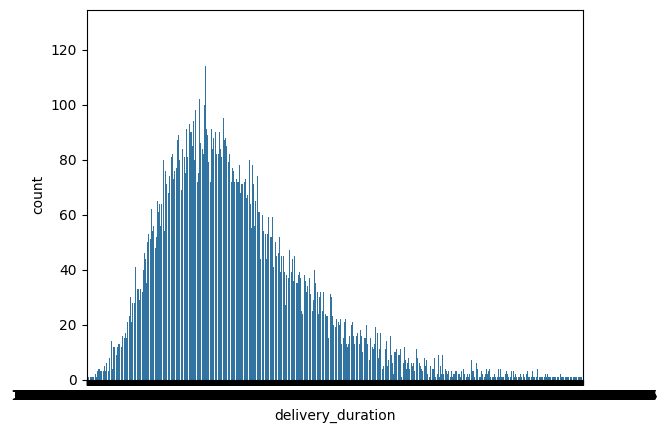

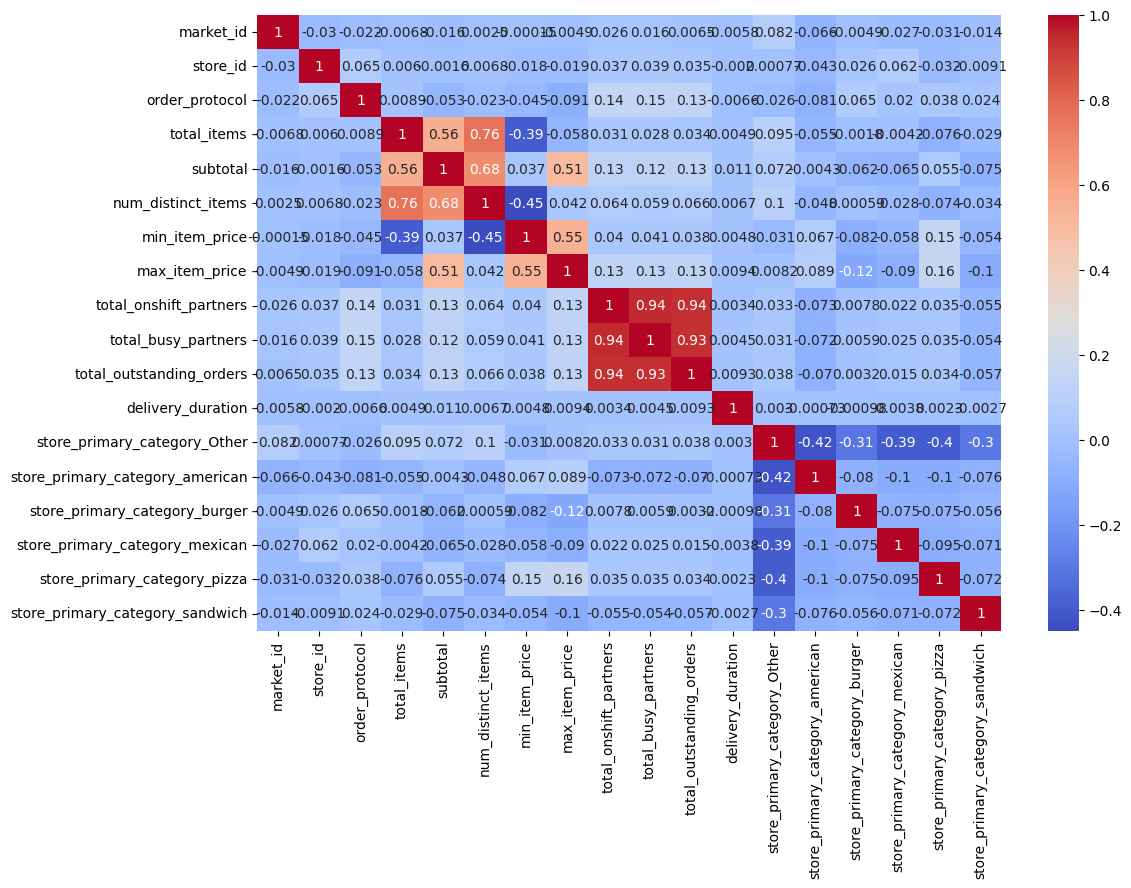

In [15]:
# Κατανομή της target
sns.countplot(x="delivery_duration", data=df)
plt.show()

# Heatmap συσχετίσεων
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.show()

In [16]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.5f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [17]:
x = df.drop(columns=['delivery_duration'])
y = df['delivery_duration']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Model training & evaluation

In [59]:
lr = LinearRegression()
lr.fit(X_train, y_train)

preds_lr = lr.predict(X_test)
mae_lr = mean_absolute_error(y_test, preds_lr)

print("Linear Regression MAE:", mae_lr)

Linear Regression MAE: 12.81237633057674


In [60]:
dt = DecisionTreeRegressor(
    max_depth=10,
    random_state=42
)
dt.fit(X_train, y_train)

preds_dt = dt.predict(X_test)
mae_dt = mean_absolute_error(y_test, preds_dt)

print("Decision Tree MAE:", mae_dt)

Decision Tree MAE: 16.210532756858242


In [61]:
rf = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

preds_rf = rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, preds_rf)

print("Random Forest MAE:", mae_rf)

Random Forest MAE: 13.60006082792206


In [62]:
model_xgb = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42
)
model_xgb.fit(X_train, y_train)

preds_xgb = model_xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, preds_xgb)

print("XGBoost MAE:", mae_xgb)

XGBoost MAE: 15.161024443579828


## Models Tuning

In [93]:
lm=Ridge(fit_intercept=True)
params = {
    'alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500]
}
ridgesearch=GridSearchCV(lm , param_grid=params , cv=5 ,n_jobs=-1,  scoring='neg_mean_absolute_error' ,  verbose=30)
ridgesearch.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,estimator,Ridge()
,param_grid,"{'alpha': [0.01, 0.05, ...]}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,30
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,500


In [94]:
print("Best parameters:", ridgesearch.best_params_, "\n")
print("Best CV MAE:", ridgesearch.best_score_, "\n")
print("Best Model:", ridgesearch.best_estimator_, "\n")
report(ridgesearch.cv_results_, 2)

Best parameters: {'alpha': 500} 

Best CV MAE: -13.723018464890833 

Best Model: Ridge(alpha=500) 

Model with rank: 1
Mean validation score: -13.723 (std: 1.71882)
Parameters: {'alpha': 500}

Model with rank: 2
Mean validation score: -13.724 (std: 1.71838)
Parameters: {'alpha': 100}



In [95]:
best_model = ridgesearch.best_estimator_
preds_rs = best_model.predict(X_test)
mae_rs = mean_absolute_error(y_test, preds_rs)

print("RidgeSearch MAE:", mae_rs)

RidgeSearch MAE: 12.81157497892258


In [ ]:
xgb_model = XGBRegressor()

param_tuning = {
        #'learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5, 0.7],
        #'max_depth': [3, 5, 7, 10],
        #'min_child_weight': [1, 3, 5],
        #'subsample': [0.5, 0.7],
        #'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [250, 500, 750, 1000],
        'objective': ['count:poisson']}

xgbsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = 20,
                           verbose = 30)

xgbsearch.fit(X_train, y_train)
print(xgbsearch.best_params_)
print(report(xgbsearch.cv_results_,5))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'n_estimators': 500, 'objective': 'count:poisson'}
Model with rank: 1
Mean validation score: -12.505 (std: 1.86232)
Parameters: {'n_estimators': 500, 'objective': 'count:poisson'}

Model with rank: 2
Mean validation score: -12.508 (std: 1.86639)
Parameters: {'n_estimators': 250, 'objective': 'count:poisson'}

Model with rank: 3
Mean validation score: -12.529 (std: 1.86033)
Parameters: {'n_estimators': 750, 'objective': 'count:poisson'}

Model with rank: 4
Mean validation score: -12.562 (std: 1.85879)
Parameters: {'n_estimators': 1000, 'objective': 'count:poisson'}

None


In [100]:
param_tuning = {
        'learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5, 0.7],
        #'max_depth': [3, 5, 7, 10],
        #'min_child_weight': [1, 3, 5],
        #'subsample': [0.5, 0.7],
        #'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [500],
        'objective': ['count:poisson']}

xgbsearch2 = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = 20,
                           verbose = 30)

xgbsearch2.fit(X_train, y_train)
print(xgbsearch2.best_params_)
print(report(xgbsearch2.cv_results_,5))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'learning_rate': 0.25, 'n_estimators': 500, 'objective': 'count:poisson'}
Model with rank: 1
Mean validation score: -12.515 (std: 1.84284)
Parameters: {'learning_rate': 0.25, 'n_estimators': 500, 'objective': 'count:poisson'}

Model with rank: 2
Mean validation score: -12.521 (std: 1.85942)
Parameters: {'learning_rate': 0.1, 'n_estimators': 500, 'objective': 'count:poisson'}

Model with rank: 3
Mean validation score: -12.623 (std: 1.84729)
Parameters: {'learning_rate': 0.05, 'n_estimators': 500, 'objective': 'count:poisson'}

Model with rank: 4
Mean validation score: -12.650 (std: 1.84950)
Parameters: {'learning_rate': 0.5, 'n_estimators': 500, 'objective': 'count:poisson'}

Model with rank: 5
Mean validation score: -12.890 (std: 1.82114)
Parameters: {'learning_rate': 0.7, 'n_estimators': 500, 'objective': 'count:poisson'}

None


In [101]:
param_tuning = {
        'learning_rate': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35],
        #'max_depth':  [3, 5, 7, 10, 12, 15],
        #'min_child_weight': [1, 3, 5],
        #'subsample': [0.5, 0.7],
        #'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [250, 500],
        'objective': ['count:poisson']}

xgbsearch3 = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = 20,
                           verbose = 30)

xgbsearch3.fit(X_train, y_train)
print(xgbsearch3.best_params_)
print(report(xgbsearch3.cv_results_,5))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'learning_rate': 0.2, 'n_estimators': 500, 'objective': 'count:poisson'}
Model with rank: 1
Mean validation score: -12.500 (std: 1.85066)
Parameters: {'learning_rate': 0.2, 'n_estimators': 500, 'objective': 'count:poisson'}

Model with rank: 2
Mean validation score: -12.501 (std: 1.84590)
Parameters: {'learning_rate': 0.15, 'n_estimators': 500, 'objective': 'count:poisson'}

Model with rank: 3
Mean validation score: -12.505 (std: 1.86232)
Parameters: {'learning_rate': 0.3, 'n_estimators': 500, 'objective': 'count:poisson'}

Model with rank: 4
Mean validation score: -12.508 (std: 1.86639)
Parameters: {'learning_rate': 0.3, 'n_estimators': 250, 'objective': 'count:poisson'}

Model with rank: 5
Mean validation score: -12.515 (std: 1.84284)
Parameters: {'learning_rate': 0.25, 'n_estimators': 500, 'objective': 'count:poisson'}

None


In [102]:
param_tuning = {
        'learning_rate': [0.15, 0.2],
        'max_depth':  [3, 5, 7, 10, 12, 15],
        #'min_child_weight': [1, 3, 5],
        #'subsample': [0.5, 0.7],
        #'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [500],
        'objective': ['count:poisson']}

xgbsearch4 = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = 20,
                           verbose = 30)

xgbsearch4.fit(X_train, y_train)
print(xgbsearch4.best_params_)
print(report(xgbsearch4.cv_results_,5))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 500, 'objective': 'count:poisson'}
Model with rank: 1
Mean validation score: -12.490 (std: 1.87182)
Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 500, 'objective': 'count:poisson'}

Model with rank: 2
Mean validation score: -12.491 (std: 1.84527)
Parameters: {'learning_rate': 0.15, 'max_depth': 7, 'n_estimators': 500, 'objective': 'count:poisson'}

Model with rank: 3
Mean validation score: -12.495 (std: 1.85131)
Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 500, 'objective': 'count:poisson'}

Model with rank: 4
Mean validation score: -12.514 (std: 1.87007)
Parameters: {'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 500, 'objective': 'count:poisson'}

Model with rank: 5
Mean validation score: -12.845 (std: 1.76776)
Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 500, 'objective': 'count:poisson'}

None


In [103]:
param_tuning = {
        'learning_rate': [0.2],
        'max_depth':  [5],
        'min_child_weight': [5, 10, 15, 50, 100, 150, 200],
        #'subsample': [0.5, 0.7],
        #'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [500],
        'objective': ['count:poisson']}

xgbsearch4 = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = 20,
                           verbose = 30)

xgbsearch4.fit(X_train, y_train)
print(xgbsearch4.best_params_)
print(report(xgbsearch4.cv_results_,5))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 200, 'n_estimators': 500, 'objective': 'count:poisson'}
Model with rank: 1
Mean validation score: -12.484 (std: 1.87198)
Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 200, 'n_estimators': 500, 'objective': 'count:poisson'}

Model with rank: 2
Mean validation score: -12.487 (std: 1.87482)
Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 150, 'n_estimators': 500, 'objective': 'count:poisson'}

Model with rank: 3
Mean validation score: -12.490 (std: 1.87182)
Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500, 'objective': 'count:poisson'}

Model with rank: 3
Mean validation score: -12.490 (std: 1.87182)
Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 500, 'objective': 'count:poisson'}

Model with rank: 3
Mean validation score: -12.490 (std: 

In [104]:
param_tuning = {
        'learning_rate': [0.2],
        'max_depth':  [5],
        'min_child_weight': [150, 175, 200],
        'subsample': [0.1, 0.2, 0.5, 0.7, 0.9],
        #'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [500],
        'objective': ['count:poisson']}

xgbsearch4 = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = 20,
                           verbose = 30)

xgbsearch4.fit(X_train, y_train)
print(xgbsearch4.best_params_)
print(report(xgbsearch4.cv_results_,5))

Fitting 5 folds for each of 15 candidates, totalling 75 fits
{'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 175, 'n_estimators': 500, 'objective': 'count:poisson', 'subsample': 0.9}
Model with rank: 1
Mean validation score: -12.478 (std: 1.86616)
Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 175, 'n_estimators': 500, 'objective': 'count:poisson', 'subsample': 0.9}

Model with rank: 2
Mean validation score: -12.478 (std: 1.87271)
Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 150, 'n_estimators': 500, 'objective': 'count:poisson', 'subsample': 0.9}

Model with rank: 3
Mean validation score: -12.479 (std: 1.88006)
Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 200, 'n_estimators': 500, 'objective': 'count:poisson', 'subsample': 0.9}

Model with rank: 4
Mean validation score: -12.495 (std: 1.87004)
Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 200, 'n_estimators': 500, 'objective'

In [105]:
param_tuning = {
        'learning_rate': [0.2],
        'max_depth':  [5],
        'min_child_weight': [175],
        'subsample': [0.9],
        'colsample_bytree': [0.1, 0.2, 0.5, 0.7, 0.9],
        'n_estimators' : [500],
        'objective': ['count:poisson']}

xgbsearch4 = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = 20,
                           verbose = 30)

xgbsearch4.fit(X_train, y_train)
print(xgbsearch4.best_params_)
print(report(xgbsearch4.cv_results_,5))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 175, 'n_estimators': 500, 'objective': 'count:poisson', 'subsample': 0.9}
Model with rank: 1
Mean validation score: -12.478 (std: 1.86565)
Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 175, 'n_estimators': 500, 'objective': 'count:poisson', 'subsample': 0.9}

Model with rank: 2
Mean validation score: -12.495 (std: 1.86415)
Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 175, 'n_estimators': 500, 'objective': 'count:poisson', 'subsample': 0.9}

Model with rank: 3
Mean validation score: -12.507 (std: 1.86483)
Parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 175, 'n_estimators': 500, 'objective': 'count:poisson', 'subsample': 0.9}

Model with rank: 4
Mean validation score: -12.752 (std: 1.82323)
Parameter

In [107]:
best_model = xgbsearch4.best_estimator_
preds_xgbsearch = best_model.predict(X_test)
mae_xgbsearch = mean_absolute_error(y_test, preds_xgbsearch)

print("XGBSearch MAE:", mae_xgbsearch)

XGBSearch MAE: 11.73577060365349
